In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

import os

import pickle

from helpers.make_BC import train_NN, np_to_torch
from helpers.physics_functions import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")


cuda available: True


In [3]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [4]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

project_id = "dimu_supp"
particle_type = "eta_shifted"

flow_training_id = f"lowmass_{particle_type}_nojet_{project_id}"
flow_training_dir = os.path.join("models", f"{flow_training_id}/")

with open(f"models/{flow_training_id}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"processed_data/lowmass_{particle_type}_nojet_test_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
    
with open(f"processed_data/lowmass_{particle_type}_nojet_samesign_band_data", "rb") as infile: 
    samesign_dict = pickle.load(infile)
    
    
with open(f"models/{flow_training_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)
    


feature_set = ['dimu_pt', 'dimu_eta', 'mumu_deltaR', 'mumu_deltapT', 'dimu_mass']



In [5]:
# Assemble the test set -- consists of both SB and SR

feature_set = ['dimu_pt', 'dimu_eta', 'mumu_deltaR', 'mumu_deltapT', 'dimu_mass']


num_events_test_SR = test_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_test_SB = test_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+test_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_samesign = samesign_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]

test_events_SB = np.empty((num_events_test_SB, len(feature_set)))
test_events_SR = np.empty((num_events_test_SR, len(feature_set)))
test_events_samesign = np.empty((num_events_samesign, len(feature_set)))


for i, feat in enumerate(feature_set):
    
    test_events_SR[:,i] = test_dict["SR"]["s_inj_data"][feat].reshape(-1,)
    loc_arr = np.concatenate((test_dict["SBL"]["s_inj_data"][feat], test_dict["SBH"]["s_inj_data"][feat]))
    test_events_SB[:,i] = loc_arr.reshape(-1,)

    
    loc_arr = np.concatenate((samesign_dict["SR"]["s_inj_data"][feat], samesign_dict["SBL"]["s_inj_data"][feat], samesign_dict["SBH"]["s_inj_data"][feat]))
    test_events_samesign[:,i] = loc_arr.reshape(-1,)





    
print(f"Total number of test events: {test_events_SR.shape[0]+test_events_SB.shape[0]}. {test_events_SR.shape[0]} in SR, {test_events_SB.shape[0]} in SB.")


Total number of test events: 99999. 26566 in SR, 73433 in SB.


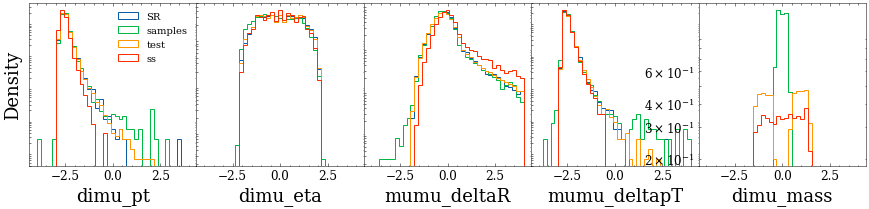

In [6]:
def hist_all_features(samples, labels, feature_set, plot_bound=3, yscale_log=False):
    scaled_feature_bins = [np.linspace(-plot_bound, plot_bound, 40) for i in range(len(feature_set))]   
    
    n_features = len(feature_set)
    fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))
        

    for i, feat in enumerate(feature_set):
        for j, samp in enumerate(samples):
            ax[i].hist(samp[:,i], bins = scaled_feature_bins[i], histtype = "step", density = True, label = labels[j])
         
        if yscale_log:
            ax[i].set_yscale("log")
        ax[i].set_xlabel(feat)
        ax[i].set_yticks([])
    ax[0].legend()
    ax[0].set_ylabel("Density")
    plt.subplots_adjust(wspace=0)
    plt.show()
  

hist_all_features([data_dict["SR"], data_dict["SR_samples"], test_events_SB, test_events_samesign], ["SR", "samples", "test", "ss"], feature_set, plot_bound = 4, yscale_log = True)



## Train the BDTs

Train to discriminate (flow samples in SR) from (test data in SR)

In [7]:
import xgboost as xgb

# BDT HYPERPARAMETERS 
n_estimators = 600 # number of boosting stages
max_depth = 2 # max depth of individual regression estimators; related to complexity
learning_rate = 0.1
subsample = 0.8 # fraction of samples to be used for fitting the individual base learners
early_stopping_rounds = 20 # stop training BDT is validation loss doesn't improve after this many rounds



In [8]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, num_to_ensemble, 
                      alt_test_sets_data={}, network_type="bdt", visualize=True):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    
    Note that alt test sets are NOT split into folds, since we aren't training on them. We do get diff scores for each fold
    """
    
    test_data_splits = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    alt_scores_splits = {}
    for alt_id in alt_test_sets_data.keys():
        alt_scores_splits[alt_id] = {i:0 for i in range(num_folds)}
        
        
    np.random.shuffle(flow_samples_SR)
    np.random.shuffle(data_samples_SR)
    np.random.shuffle(data_samples_SB)
    
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds)
    
    for i_fold in range(num_folds):
            
        print(f"Fold {i_fold}:")
        
        """
        ASSEMBLE THE TRAIN / VAL / TEST DATA
        """
        
        # Assemble the train / test data in a hacky way
        training_data = []
        training_labels = []
        validation_data = []
        validation_labels = []
        testing_data = []
        
        for ii in range(num_folds):
            
            if ii == i_fold:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
            elif ((ii+1)%num_folds) == i_fold:
                validation_data.append(flow_SR_splits[ii])
                validation_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                validation_data.append(data_SR_splits[ii])
                validation_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
            else:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_val_fold = np.concatenate(validation_data)
        Y_val_fold = np.concatenate(validation_labels)
        X_test_fold = np.concatenate(testing_data)
        
        # save out the local fold data
        test_data_splits[i_fold] = X_test_fold

        # but really, we only want to train on the non-mass features
        X_train_fold = X_train_fold[:,:-1]
        X_val_fold = X_val_fold[:,:-1]
        X_test_fold = X_test_fold[:,:-1]
        
        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}. X test shape: {X_test_fold.shape}." )
        print(f"X val shape: {X_val_fold.shape}, Y val shape: {Y_val_fold.shape}." )
                
        # adjust for class weights
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights_train = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold
        class_weights_val = class_weight[0]*(1.0-Y_val_fold)+class_weight[1]*Y_val_fold
        

        print("Training class weights: ", class_weight)
        #Y_train_fold = Y_train_fold.reshape(-1,)
        #class_weights = class_weights.reshape(-1,)
        
        """
        INITIALIZE SCORE OBJECTS
        """
        scores_fold = np.empty((X_test_fold.shape[0], num_to_ensemble))
        alt_scores_fold = {}
        for alt_id in alt_test_sets_data.keys():
            alt_scores_fold[alt_id] = np.empty((alt_test_sets_data[alt_id].shape[0], num_to_ensemble))
            
   
        """
        TRAIN ENSEMBLE OF TREES
        """
    
        if visualize:
            plt.figure()
        
        for i_tree in range(num_to_ensemble):
            
            print("   Network number:", i_tree)
            random_seed = i_fold*num_to_ensemble + i_tree + 1
                
            if network_type == "bdt":
                eval_set = [(X_train_fold, Y_train_fold), (X_val_fold, Y_val_fold)]

                bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                                  subsample=subsample,early_stopping_rounds=early_stopping_rounds,
                                  objective='binary:logistic', random_state = random_seed, eval_metric="logloss")

                bst_i.fit(X_train_fold, Y_train_fold, sample_weight=class_weights_train, 
                          eval_set=eval_set, sample_weight_eval_set = [class_weights_train, class_weights_val],
                          verbose=False)
                results_f = bst_i.evals_result()
                losses = results_f["validation_0"]["logloss"]
                losses_val = results_f["validation_1"]["logloss"]
                best_epoch = bst_i.best_iteration
                
                
                # get scores
                scores_fold[:,i_tree] = bst_i.predict_proba(X_test_fold, iteration_range=(0,bst_i.best_iteration))[:,1]
                for alt_id in alt_test_sets_data.keys():
                    alt_scores_fold[alt_id][:,i_tree] = bst_i.predict_proba(alt_test_sets_data[alt_id][:,:-1], iteration_range=(0,bst_i.best_iteration))[:,1]
            
            elif network_type == "nn":

                results_path = "loc_nn"
                loc_scaler, losses, losses_val, best_epoch = train_NN(X_train_fold, Y_train_fold, class_weights_train, 
                                                            X_val_fold, Y_val_fold, class_weights_val, random_seed, 
                                                            [64, 64, 64], hyperparameters_dict_BC, device, results_path=results_path)
        
                dense_net_eval = torch.load(f"{results_path}.pt")
                dense_net_eval.eval()
                with torch.no_grad():
                    scores_fold[:,i_tree] = dense_net_eval(np_to_torch(loc_scaler.transform(X_test_fold), device)).detach().cpu().numpy().reshape(-1,)
                    for alt_id in alt_test_sets_data.keys():
                        alt_scores_fold[alt_id][:,i_tree] =  dense_net_eval(np_to_torch(loc_scaler.transform(alt_test_sets_data[alt_id][:,:-1]), device)).detach().cpu().numpy().reshape(-1,)
            
            if visualize:
                
                plt.plot(losses, label = f"{i_tree}", color = f"C{i_tree}")
                plt.plot(losses_val, color = f"C{i_tree}", linestyle = "dashed")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.axvline(best_epoch, color = f"C{i_tree}")
                plt.title(f"Fold {i_fold}")
        
        if visualize:
            plt.legend()
            plt.show()
        
            
            
        """
        AVERAGE OVER ENSEMBLE
        """
            
        scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
        for alt_id in alt_test_sets_data.keys():
            alt_scores_splits[alt_id][i_fold] = np.mean(alt_scores_fold[alt_id], axis = 1)
            
        print()


    return test_data_splits, scores_splits, alt_scores_splits




Fold 0:
X train shape: (26925, 4), Y train shape: (26925, 1). X test shape: (20001, 4).
X val shape: (8975, 4), Y val shape: (8975, 1).
Training class weights:  {0: 1, 1: 0.6892527762092979}
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19
   Network number: 20
   Network number: 21
   Network number: 22
   Network number: 23
   Network number: 24


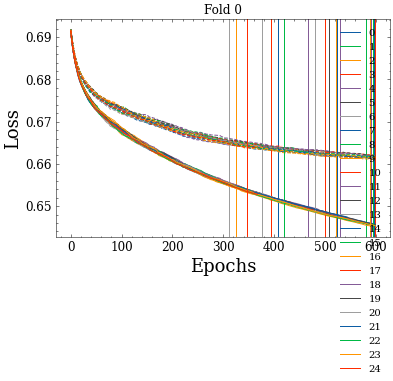


Fold 1:
X train shape: (26925, 4), Y train shape: (26925, 1). X test shape: (20000, 4).
X val shape: (8977, 4), Y val shape: (8977, 1).
Training class weights:  {0: 1, 1: 0.6892527762092979}
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19
   Network number: 20
   Network number: 21
   Network number: 22
   Network number: 23
   Network number: 24


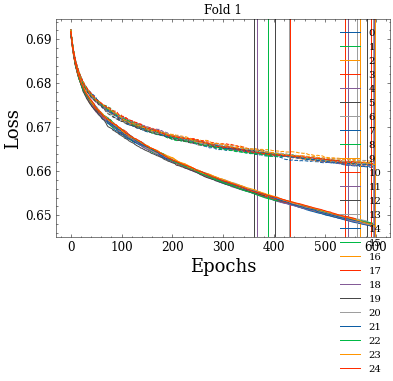


Fold 2:
X train shape: (26927, 4), Y train shape: (26927, 1). X test shape: (20000, 4).
X val shape: (8975, 4), Y val shape: (8975, 1).
Training class weights:  {0: 1, 1: 0.6892722710163112}
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19
   Network number: 20
   Network number: 21
   Network number: 22
   Network number: 23
   Network number: 24


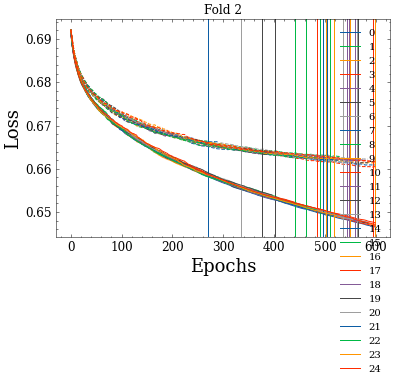


Fold 3:
X train shape: (26927, 4), Y train shape: (26927, 1). X test shape: (19999, 4).
X val shape: (8975, 4), Y val shape: (8975, 1).
Training class weights:  {0: 1, 1: 0.6892722710163112}
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19
   Network number: 20
   Network number: 21
   Network number: 22
   Network number: 23
   Network number: 24


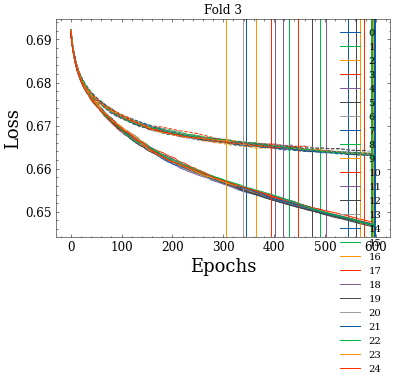


Fold 4:
X train shape: (26927, 4), Y train shape: (26927, 1). X test shape: (19999, 4).
X val shape: (8975, 4), Y val shape: (8975, 1).
Training class weights:  {0: 1, 1: 0.6892722710163112}
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19
   Network number: 20
   Network number: 21
   Network number: 22
   Network number: 23
   Network number: 24


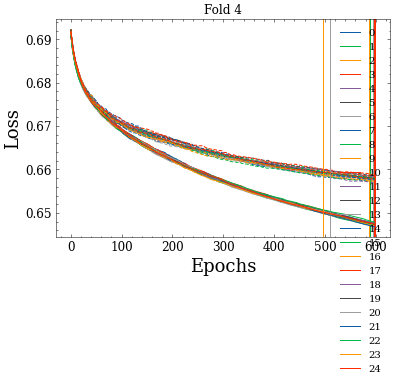

In [9]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5
n_to_ensemble = 25


# NN
hyperparameters_dict_BC = {"n_epochs":100,
                              "batch_size": 256,
                              "lr": .001,
                             }




test_data_splits, scores_splits, alt_scores_splits = run_BDT_bump_hunt(data_dict["SR_samples"], 
                                        test_events_SR, test_events_SB, n_folds, n_to_ensemble, 
                                            alt_test_sets_data = {"FPR_validation":data_dict["SR_samples_validation"],"samesign":test_events_samesign},
                                                                      network_type="bdt", visualize=True)



## Analysis

### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [ ]:
with open(f"processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
sorted_masses_splits = {}

fpr_thresholds = [1,  .7, 0.4, 0.1, 0.05, 0.01]
score_cutoffs = {i:[] for i in range(n_folds)}


for i_fold in range(n_folds):
    
    """ 
    # OLD METHOD: SORTING SCORES
    # sort the scores
    loc_sorted_indices = np.argsort(scores_splits[i_fold])
    
    # get the true masses from low to high score
    sorted_masses_splits[i_fold] = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1][loc_sorted_indices]).reshape(-1,1))
   
    
    plt.figure()
    plt.hist(alt_scores_splits["FPR_validation"][i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "FPR")
    plt.hist(scores_splits[i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "test")
    plt.hist(alt_scores_splits["samesign"][i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "ss")
    plt.legend()
    plt.show()
    """
    
    # NEW METHOD: score cutoff from vaidation fpr
    # from EBH paper
    
    for t in fpr_thresholds:
        
        loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold])
        score_cutoff = 1-loc_scores_sorted[min(int(t*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
   
        score_cutoffs[i_fold].append(score_cutoff)  
print(score_cutoffs)

In [ ]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
    
plot_bins_SR = np.linspace(SR_left, SR_right, 6)
x_SR_center = 0.5*(plot_bins_SR[1:] + plot_bins_SR[:-1])
width = plot_bins_SR[1] - plot_bins_SR[0]
x = np.linspace(SB_left, SB_right, 100)


remove_edge = True



fit_type = "cubic"

if fit_type == "cubic":
    p0  = [5000, -20000, 30000, -10000]
    bkg_fit_function = bkg_fit_cubic
    n_dof_fit = 4
    
elif fit_type == "quintic":
    p0  = [5000, -20000, 30000, -10000, 0, 0]
    bkg_fit_function = bkg_fit_quintic
    n_dof_fit = 6
    
elif fit_type == "ratio":
    p0  = [1000,1000,0.1]
    bkg_fit_function = bkg_fit_ratio
    n_dof_fit = 3


plt.figure(figsize = (12, 9))
#for p, percent in enumerate([100, 80, 60, 40, 20]):
for p, threshold in enumerate(fpr_thresholds):
    
        
    filtered_masses = []
    
    for i_fold in range(n_folds):
        """
        # grab the top percent of events FROM EACH FOLD
        loc_num_events_to_take = int(percent*sorted_masses_splits[i_fold].shape[0]/100)
        filtered_masses.append(np.array(sorted_masses_splits[i_fold][-loc_num_events_to_take:]).reshape(-1,1))
        """
        
        # get the true masses
        loc_true_masses = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1]).reshape(-1,1))
        # get the events that pass the score threshold
        pass_scores = scores_splits[i_fold] >= score_cutoffs[i_fold][p]
        filtered_masses.append(loc_true_masses[pass_scores])
        

    filtered_masses = np.concatenate(filtered_masses)
    
    
    popt, pcov, chi2, dof_data, plot_bins_left, plot_bins_right = curve_fit_m_inv(filtered_masses, bkg_fit_function, SB_left, SB_right, SR_left, SR_right, width, p0, remove_edge = True)
    #print(popt)
    
    plot_bins = np.concatenate([plot_bins_left, plot_bins_SR, plot_bins_right])
    plot_centers = 0.5*(plot_bins[1:] + plot_bins[:-1])

    n_dof = dof_data - n_dof_fit
    print("chi2/dof:", chi2/n_dof)
    
    plt.plot(plot_centers, bkg_fit_function(plot_centers, *popt), lw = 2, linestyle = "dashed", color = f"C{p}")
    #plt.scatter(plot_centers, bkg_fit_function(plot_centers, *popt),color = f"C{p}")
    
    
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, bkg_fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, x_SR_center, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins, lw = 3, histtype = "step", color = f"C{p}",label = label_string)
    
    
    
    
print() 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type}\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)
plt.show()

Repeat for samesign background

In [ ]:
fit_type = "cubic"

if fit_type == "cubic":
    p0  = [5000, -20000, 30000, -10000]
    bkg_fit_function = bkg_fit_cubic
    n_dof_fit = 4
    
elif fit_type == "quintic":
    p0  = [5000, -20000, 30000, -10000, 0, 0]
    bkg_fit_function = bkg_fit_quintic
    n_dof_fit = 6
    
elif fit_type == "ratio":
    p0  = [1000,1000,0.1]
    bkg_fit_function = bkg_fit_ratio
    n_dof_fit = 3


plt.figure(figsize = (12, 9))
#for p, percent in enumerate([100, 80, 60, 40, 20]):
for p, threshold in enumerate(fpr_thresholds):
        
    filtered_masses = []
    
    for i_fold in range(n_folds):
        """
        loc_sorted_indices = np.argsort(alt_scores_splits["samesign"][i_fold])
        loc_sorted_masses = scaler.inverse_transform(np.array(test_events_samesign[:,-1][loc_sorted_indices]).reshape(-1,1))

        
        # grab the top percent of events FROM EACH FOLD
        loc_num_events_to_take = int(percent*loc_sorted_masses.shape[0]/100)
        filtered_masses.append(np.array(loc_sorted_masses[-loc_num_events_to_take:]).reshape(-1,1))
        """
        
        # get the true masses
        loc_true_masses = scaler.inverse_transform(test_events_samesign[:,-1].reshape(-1,1))
        # get the events that pass the score threshold
        pass_scores = alt_scores_splits["samesign"][i_fold] >= score_cutoffs[i_fold][p]
        filtered_masses.append(loc_true_masses[pass_scores])
        
        
    filtered_masses = np.concatenate(filtered_masses)
    
    popt, pcov, chi2, dof_data, plot_bins_left, plot_bins_right = curve_fit_m_inv(filtered_masses, bkg_fit_function, SB_left, SB_right, SR_left, SR_right, width, p0, remove_edge = True)
    #print(popt)
    
    plot_bins = np.concatenate([plot_bins_left, plot_bins_SR, plot_bins_right])
    plot_centers = 0.5*(plot_bins[1:] + plot_bins[:-1])

    n_dof = dof_data - n_dof_fit
    print("chi2/dof:", chi2/n_dof)
    
    plt.plot(plot_centers, bkg_fit_function(plot_centers, *popt), lw = 2, linestyle = "dashed", color = f"C{p}")
    #plt.scatter(plot_centers, bkg_fit_function(plot_centers, *popt),color = f"C{p}")
    
    
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, bkg_fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, x_SR_center, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins, lw = 3, histtype = "step", color = f"C{p}",label = label_string)
    
    
    
    
    
#plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type} same sign", fontsize = 24)

plt.show()